In [49]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = 'byC6Gdt4zfRyj6yMUnYC'
selected = ['AAPL', 'BAC', 'C', 'GM', 'FB']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
date = { 'gte': '2017-6-1', 'lte': '2018-6-1' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-27,GM,34.87
1,2018-03-26,GM,35.99
2,2018-03-23,GM,35.17
3,2018-03-22,GM,36.35
4,2018-03-21,GM,37.58


In [50]:
table = data.set_index('date').pivot(columns='ticker')
table.head()

adj_close                                         
ticker            AAPL        BAC          C      FB         GM
date                                                           
2017-06-01  152.560992  22.516803  60.532867  151.53  33.706159
2017-06-02  154.821818  22.337703  60.562599  153.61  33.725738
2017-06-05  153.307961  22.297903  60.701345  153.63  33.735528
2017-06-06  153.825860  22.118804  60.463494  152.81  33.706159
2017-06-07  154.742142  22.486953  61.325701  153.12  33.990062

In [51]:
# calculate daily and annual returns of the stocks
selected = table.columns.get_level_values(1).values
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
'Sharpe Ratio': sharpe_ratio}

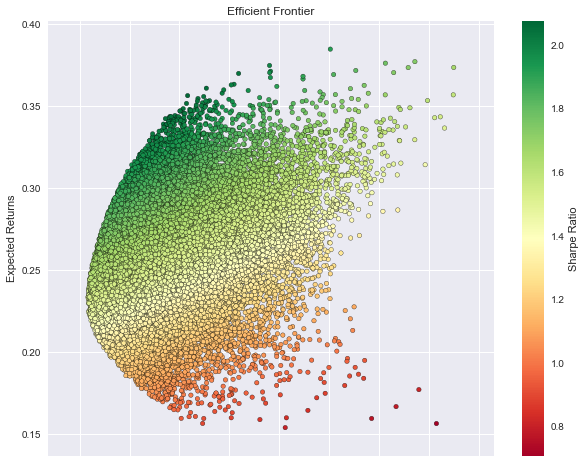

In [48]:
%matplotlib inline
# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

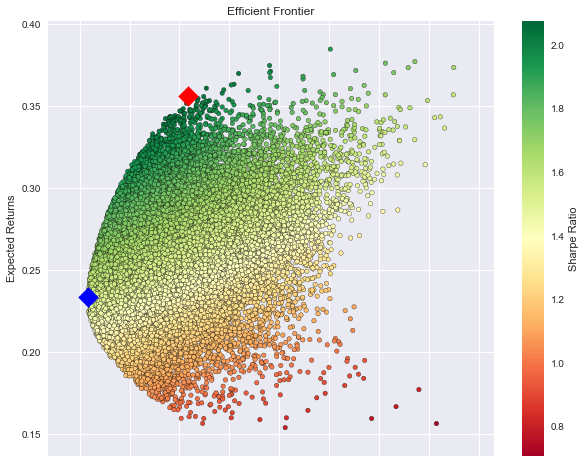

In [52]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [53]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                 34035
Returns       0.233586
Volatility    0.151641
Sharpe Ratio  1.540384
AAPL Weight   0.350855
BAC Weight    0.003779
C Weight      0.221316
GM Weight     0.260803
FB Weight     0.163247
                 13159
Returns       0.356394
Volatility    0.171637
Sharpe Ratio  2.076442
AAPL Weight   0.544918
BAC Weight    0.410146
C Weight      0.012531
GM Weight     0.016681
FB Weight     0.015724
